<a href="https://colab.research.google.com/github/ZhihanX/SocialMedia_Sentiment_Analysis/blob/main/twitter_training_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U hopsworks --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 524.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 4.7 MB/s eta 0:00:00
  Preparing metad

In [2]:
import hopsworks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

In [3]:
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
for k, v in os.environ.items():
    if "HOPS" in k:
        print(f'{k}={v}')

In [5]:
project = hopsworks.login()
fs = project.get_feature_store()

Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated

Paste it here: ··········
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/188566
Connected. Call `.close()` to terminate connection gracefully.


In [36]:
twitter_fg = fs.get_feature_group(name="twi_sentiment", version=1)
query = twitter_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="twi_sentiment",
                                  version=1,
                                  description="Read from twitter dataset",
                                  labels=["sentiment"],
                                  query=query)

In [37]:
twitter_fg

In [38]:
i_train, i_test, o_train, o_test = feature_view.train_test_split(0.05)
o_train = o_train.iloc[:, 0:]
o_test = o_test.iloc[:, 0:]



Finished: Reading data from Hopsworks, using ArrowFlight (11.93s) 


In [39]:
o_test=o_test.reset_index(drop=True)
i_test=i_test.reset_index(drop=True)

In [40]:
X_train=i_train['text'].tolist()
X_test=i_test['text'].tolist()
y_train=o_train['sentiment'].tolist()
y_test=o_test['sentiment'].tolist()

In [41]:
X_train

['USER thanks kell kinda went in with an in between look ',
 'my room it is brothel now will need to take picture and share ',
 'USER tonight thought might need goat and then remembered you were calling and that my frustration would be gone ',
 'USER lol mit dem twittelator ',
 'maricris just told me all about her trip and now gazillion time more excited to go ohh the wait 49 day exactly ',
 'need nap today so tired and am sad that it is the last day of school will miss elementary school ',
 'having blast love this job already finished the whole first season of the simpson now im playing skip bo ',
 'USER so not tired ',
 'USER warning first before have to look at twink thanks ',
 'USER good morning sooks happy frackin friday ',
 'is bored out of his tree and want something to do ',
 'just downloaded some old 90 song that soo good hearing something oold ',
 'why isn away we go playing in the great state of tennessee ',
 'shit end to the dayy forced to get off my laptop night ',
 'USER 

TF-IDF Vectoriser

In [42]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
# print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.


In [43]:
vectoriser

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [44]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [45]:
X_train

<1447812x500000 sparse matrix of type '<class 'numpy.float64'>'
	with 30615889 stored elements in Compressed Sparse Row format>

# Training and Evaluating Models

In [46]:
def model_Evaluate(model):

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    cm=sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

    return cm,y_pred

BernoulliNB Model

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     38555
           1       0.79      0.81      0.80     37646

    accuracy                           0.80     76201
   macro avg       0.80      0.80      0.80     76201
weighted avg       0.80      0.80      0.80     76201



(<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted values', ylabel='Actual values'>,
 array([0, 0, 1, ..., 1, 1, 0]))

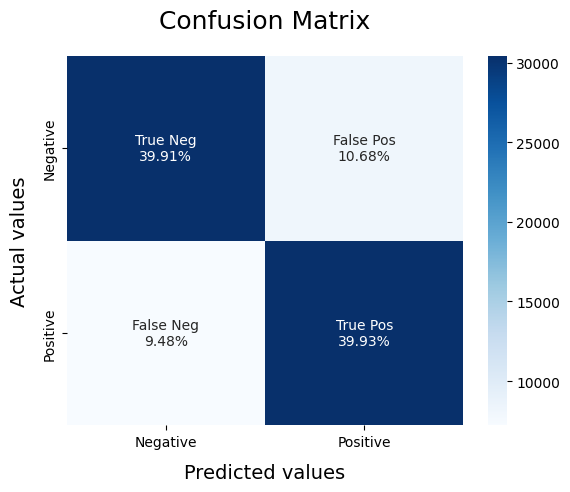

In [47]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

C-Support Vector

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     38555
           1       0.80      0.82      0.81     37646

    accuracy                           0.81     76201
   macro avg       0.81      0.81      0.81     76201
weighted avg       0.81      0.81      0.81     76201



(<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted values', ylabel='Actual values'>,
 array([0, 0, 1, ..., 1, 1, 0]))

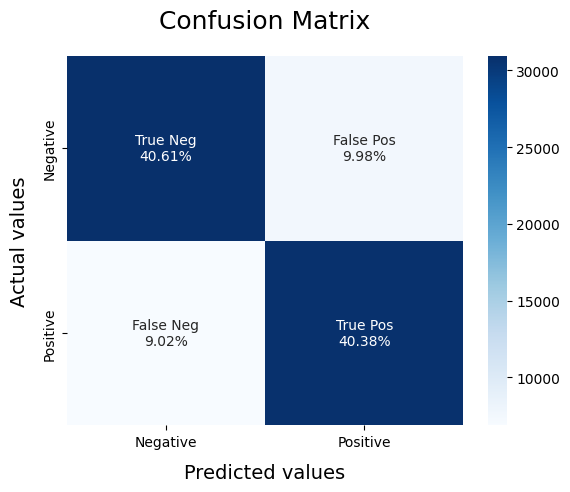

In [48]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

Logic Regression

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     38555
           1       0.81      0.83      0.82     37646

    accuracy                           0.82     76201
   macro avg       0.82      0.82      0.82     76201
weighted avg       0.82      0.82      0.82     76201



(<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted values', ylabel='Actual values'>,
 array([0, 0, 1, ..., 1, 1, 0]))

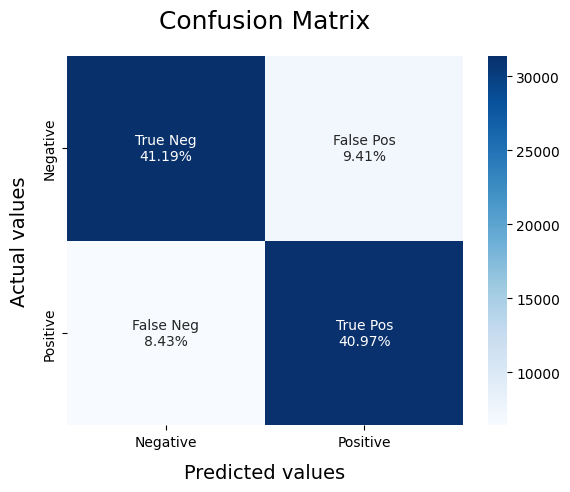

In [49]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)



Connected. Call `.close()` to terminate connection gracefully.
              precision    recall  f1-score   support

           0       0.83      0.81      0.82     38555
           1       0.81      0.83      0.82     37646

    accuracy                           0.82     76201
   macro avg       0.82      0.82      0.82     76201
weighted avg       0.82      0.82      0.82     76201



  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/68430519 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/4000863 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/32917 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/249 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/188566/models/twi_model_new/2


Model(name: 'twi_model_new', version: 2)

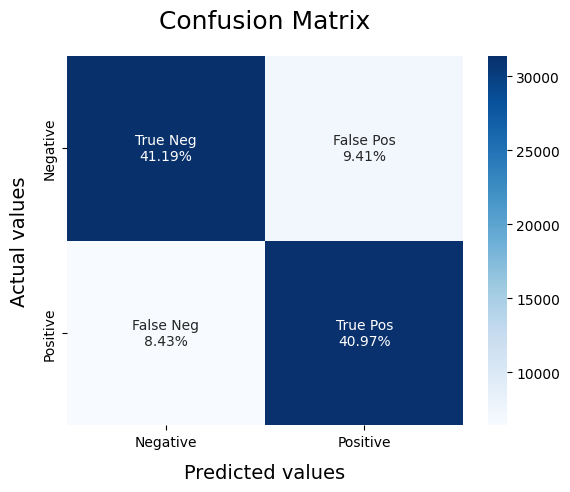

In [50]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()
cm,o_pred = model_Evaluate(LRmodel)
fig = cm.get_figure()
# The contents of the 'twi_model' directory will be saved to the model registry. Create the dir, first.
model_dir="twi_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(LRmodel, model_dir + "/twi_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")
joblib.dump(vectoriser, model_dir+'/tfidf_vectoriser.joblib')
# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(i_train)
output_schema = Schema(o_train)
model_schema = ModelSchema(input_schema, output_schema)
metrics = classification_report(o_pred, o_test, output_dict=True)

# Create an entry in the model registry that includes the model's name, desc, metrics
twi_model = mr.python.create_model(
    name="twi_model_new",
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Twi sentiment Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
twi_model.save(model_dir)